In [220]:
import pandas as pd
import numpy as np
from maxijdefs import *
from maxij_nicerdefs import *
import glob
from itertools import groupby
from datetime import datetime
from scipy.signal import fftconvolve
import matplotlib
import matplotlib.pyplot as plt
from pylab import subplot, subplots_adjust, legend
%matplotlib inline

In [2]:
# info for reading x-ray data (directory and filter for night)
# for example, for 3/28 the NICER date is 113
# filename_filter = 'ni1200120113_0mpu7_silver_GTI*.lc' # for 3/28
xpathnam = 'delivery/'
filename_filter = '*_0mpu7_silver_GTI*.lc'

# info to read rho optical data (directory and night)
opathnam = './maxij_data_copies/'
onights = ['2018-03-28'] # put other nights here
night = onights[0] # to pick out night. add functionality to loop over all nights later?


In [3]:
## time calibration stuff:

# computer clock is ~51.5s fast (per lab tests + SSE calculation)
# (((POSSIBLY 8.5 s slow, but this seems to work?)))
clocklag = -51.5
# clocklag = 8.5
# clocklag -=60

# do not change this! it is absolutely calibrated to the 28th.
# unix epoch timestamp - nicer absolute time
# both at 2018-03-28 08:05:21.000 UTC
dt = 1522224321-133689923
# print dt

In [4]:
## read in nicer xray data for night and make pandas df
# get filenames for night's xray data
ftest = xpathnam + filename_filter
flistD = glob.glob(ftest)

# all files
flist = [fnam.split('/')[1] for fnam in flistD]
flist = natsorted(flist)
# print len(flist)
ndat_t = []
ndat_cts = []
ndat_cts1 = []
ndat_cts2 = []
ndat_cts34 = []
ndat_fnam = []

for fileX in flist:
    t,cts=rd_nicer_lc(xpathnam,[fileX])
    t1,cts1=rd_nicer_lc1(xpathnam,[fileX])
    t2,cts2=rd_nicer_lc2(xpathnam,[fileX])
    t34,cts34=rd_nicer_lc34(xpathnam,[fileX])
    filename_column = [fileX for x in np.arange(len(t))]

    ndat_t.append(t)
    ndat_cts.append(cts)
    ndat_cts1.append(cts1)
    ndat_cts2.append(cts2)
    ndat_cts34.append(cts34)
    ndat_fnam.append(filename_column)

ndict = {'filename': [item for sublist in ndat_fnam for item in sublist],
          'time': [item for sublist in ndat_t for item in sublist],
          'cts': [item for sublist in ndat_cts for item in sublist],
          'cts1': [item for sublist in ndat_cts1 for item in sublist],
          'cts2': [item for sublist in ndat_cts2 for item in sublist],
          'cts34': [item for sublist in ndat_cts34 for item in sublist]
          }

nicerdata = pd.DataFrame(ndict, index=ndict['time'])
# print nicerdata

In [5]:
#read in optical data as pandas dataframe:
rhodata = pd.read_pickle(opathnam+'data_'+night+'.pkl')
# print data
print len(rhodata)

11729


In [6]:
# fix/calibrate time for both optical and x-ray data so that they're all using unix epoch time
rhodata['fixed_time'] = rhodata['os_time'] + clocklag
nicerdata['unix_time'] = nicerdata['time'] + dt

In [7]:
## clean up data
# test = np.abs(rhodata['gauss_params_3_sigma_x'] - rhodata['gauss_params_4_sigma_y'])
# n, bins, patches = plt.hist(test, 50, normed=1, facecolor='green', alpha=0.75)

shiftgood = rhodata['shift_corr_amplitude'] < 10.
gaussgood = rhodata['gauss_sigma_avg'] < 3.
gaussnonzero = rhodata['gauss_sigma_avg'] > 0.
gaussgood2 = np.abs(rhodata['gauss_params_3_sigma_x'] - rhodata['gauss_params_4_sigma_y']) < 1.
rhoclean = rhodata[shiftgood & gaussgood & gaussgood2 & gaussnonzero]
# plt.plot(rhodata['fixed_time'],rhodata['phot_maxij']-np.median(rhodata['phot_maxij']),'.-m')
# plt.plot(rhodata['fixed_time'],rhodata['phot_tyc']-np.median(rhodata['phot_tyc']),'.-c')
# plt.plot(rhoclean['fixed_time'],rhoclean['phot_maxij']-np.median(rhoclean['phot_maxij']),'.-r')
# plt.plot(rhoclean['fixed_time'],rhoclean['phot_tyc']-np.median(rhoclean['phot_tyc']),'.-g')
# plt.show()

In [8]:
## pull out just datasets we are going to use
xt = nicerdata['unix_time']
xlc = nicerdata['cts']
ot = rhoclean['fixed_time']
olc = rhoclean['phot_maxij']
tlc = rhoclean['phot_tyc']

In [9]:
## define timeframe based on optical data
## make 1-s timeseries' for whole night (with zeroes where no data)
optical_time_seconds = np.arange(np.floor(np.min(rhoclean['fixed_time'])),np.ceil(np.max(rhoclean['fixed_time'])))
xts = make_1s_ts(optical_time_seconds, np.array(xt),np.array(xlc)) 
ots = make_1s_ts(optical_time_seconds, np.array(ot),np.array(olc))
tts = make_1s_ts(optical_time_seconds, np.array(ot),np.array(tlc))

# plt.plot(optical_time_seconds,xts,'b.')
# plt.plot(optical_time_seconds,ots,'r.')
# plt.show()

In [42]:
## keep just overlapping data
ticks = np.arange(len(xts))
superchunk_lists= [list(zip(*group)) for k, group in groupby(zip(ticks,xts), lambda x: x[1] == 0) if not k]
n_superchunks = np.shape(superchunk_lists)[0]
t_init = []
for x in superchunk_lists: 
    print np.shape(x), np.min(x[0]), np.max(x[0])
    print x[1][0], xts[np.min(x[0])]
    print x[1][len(x[1])-1], xts[np.max(x[0])]
    t_init.append(tts[np.min(x[0])])
print t_init

## can look at times and combine some of them by hand if necessary????

(2, 185) 2470 2654
12784.0 12784.0
39128.0 39128.0
(2, 218) 2704 2921
26616.0 26616.0
16336.0 16336.0
(2, 193) 8144 8336
31904.0 31904.0
36176.0 36176.0
(2, 207) 8412 8618
27072.0 27072.0
21592.0 21592.0
[335076.81970214844, 354067.1506347656, 366137.3635253906, 360252.40322875977]


In [105]:
# ## create superchunk dataframe
# ochunks_dict= {'date' : night,
#                'time_0' : None,
               
#                         }
# ochunks_df = pd.DataFrame(overlap_superchunk_dict)

contiguous x-ray data segment:  0
initial time:  335076.81970214844
# of chunks in this segment:  3

contiguous x-ray data segment:  1
initial time:  354067.1506347656
# of chunks in this segment:  4

contiguous x-ray data segment:  2
initial time:  366137.3635253906
# of chunks in this segment:  4

contiguous x-ray data segment:  3
initial time:  360252.40322875977
# of chunks in this segment:  4

total # of overlapping chunks: 15


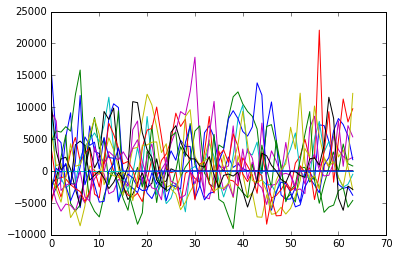

In [186]:
## just dealing with overlap data
## split into 64s chunks
csize = 64
k = 0
datadict = {}
for i in np.arange(n_superchunks):
    print "contiguous x-ray data segment: ", i
    print "initial time: ", t_init[i]
    x = superchunk_lists[i]
    superchunk_size = np.shape(x)[1]
    tickdata = x[0]
    actualtimedata = [optical_time_seconds[n] for n in tickdata]
    xdata = [xts[n] for n in tickdata]
    odata = [ots[n] for n in tickdata]
    tdata = [tts[n] for n in tickdata]
    chunkticks = np.arange(csize)
#     plt.plot(actualtimedata,xdata,'.')
    
    xts_c = chunks(xdata,csize)
    ots_c = chunks(odata,csize)
    tts_c = chunks(tdata,csize)
    time_c = chunks(actualtimedata,csize)
    tc = np.arange(csize)
    ctot = len(ots_c)
    print "# of chunks in this segment: ", ctot
    print
    
    for c in xrange(ctot): 
        # cm = median-subtracted cleaned timeseries
        xts_cm = np.zeros(np.shape(xts_c[c]))
        ots_cm = np.zeros(np.shape(ots_c[c]))
        tts_cm = np.zeros(np.shape(tts_c[c]))

        
        #m is the median of the timeseries
        xts_m = np.median(xts_c[c][xts_c[c]>0])
        ots_m = np.median(ots_c[c][ots_c[c]>0])
        tts_m = np.median(tts_c[c][tts_c[c]>0])

        # fixed = set zeroes equal to median
        xts_f = xts_cm + xts_m
        ots_f = ots_cm + ots_m
        tts_f = tts_cm + tts_m
        
        for i in xrange(ntot): 
            if xts_c[c][i] > 0: 
                xts_cm[i] = xts_c[c][i]-xts_m
                xts_f[i] = xts_c[c][i]
            if ots_c[c][i] > 0: 
                ots_cm[i] = ots_c[c][i]-ots_m
                ots_f[i] = ots_c[c][i]
            if tts_c[c][i] > 0: 
                tts_cm[i] = tts_c[c][i]-tts_m
                tts_f[i] = tts_c[c][i]

#         print xts_cm
        plt.plot(tc,xts_cm) #all 64-s chunks of data, overlapping
        chunkID = np.arange(ctot)
        chunkdict = {'unix_time':time_c[c],
                     'chunktime':tc,
                     'xray_maxij_clean_ts':xts_c[c],
                     'rho_maxij_clean_ts':ots_c[c],
                     'rho_tycho_clean_ts':tts_c[c],

                     'xray_maxij_fixed_ts':xts_f,
                     'rho_maxij_fixed_ts': ots_f,
                     'rho_tycho_fixed_ts': tts_f,

                     'xray_maxij_med_ts': xts_cm,
                     'rho_maxij_med_ts': ots_cm,
                     'rho_tycho_med_ts': tts_cm
                    }

    #     print c
    #     print ots_cm
        chunkframe = pd.DataFrame(chunkdict, index=tc)
        datadict[str(k)]= chunkframe
#         print "k = ", k
        k+=1
print 'total # of overlapping chunks:', len(datadict)
ochunk_datadict = datadict
ochunk_keys = np.arange(k)


In [180]:
# print datadict.keys()
# print ochunk_keys

In [158]:
# for i in np.arange(n_superchunks): 
# #     for c in np.arange(
#     print i, 
#     print overlap_superchunk_dict.iloc[i,'chunk64pdf']

In [187]:
## for all data 
## split into 64-s chunks
ntot = 64
xts_c = chunks(xts,ntot)
ots_c = chunks(ots,ntot)
tts_c = chunks(tts,ntot)
time_c = chunks(optical_time_seconds,ntot)
tc = np.arange(ntot)
ctot = len(ots_c)

datadict = {}
overlap = []
for c in xrange(ctot): 
    # cm = median-subtracted cleaned timeseries
    xts_cm = np.zeros(np.shape(xts_c[c]))
    ots_cm = np.zeros(np.shape(ots_c[c]))
    tts_cm = np.zeros(np.shape(tts_c[c]))
    
    #m is the median of the timeseries
    xts_m = np.median(xts_c[c][xts_c[c]>0])
    ots_m = np.median(ots_c[c][ots_c[c]>0])
    tts_m = np.median(tts_c[c][tts_c[c]>0])
    
    # fixed = set zeroes equal to median
    xts_f = xts_cm + xts_m
    ots_f = ots_cm + ots_m
    tts_f = tts_cm + tts_m
    
    for i in xrange(ntot): 
        if xts_c[c][i] > 0: 
            xts_cm[i] = xts_c[c][i]-xts_m
            xts_f[i] = xts_c[c][i]
        if ots_c[c][i] > 0: 
            ots_cm[i] = ots_c[c][i]-ots_m
            ots_f[i] = ots_c[c][i]
        if tts_c[c][i] > 0: 
            tts_cm[i] = tts_c[c][i]-tts_m
            tts_f[i] = tts_c[c][i]
            
            
    chunkID = np.arange(ctot)
    chunkdict = {'unix_time':time_c[c],
                 'chunktime':tc,
                 'xray_maxij_clean_ts':xts_c[c],
                 'rho_maxij_clean_ts':ots_c[c],
                 'rho_tycho_clean_ts':tts_c[c],
                 
                 'xray_maxij_fixed_ts':xts_f,
                 'rho_maxij_fixed_ts': ots_f,
                 'rho_tycho_fixed_ts': tts_f,
                 
                 'xray_maxij_med_ts': xts_cm,
                 'rho_maxij_med_ts': ots_cm,
                 'rho_tycho_med_ts': tts_cm
                }
    if np.sum(xts_c[c]) > 0: 
        overlap.append(c)
#         print c
#         print xts_f
#     print c
#     print ots_cm
    chunkframe = pd.DataFrame(chunkdict, index=tc)
    datadict[str(c)]= chunkframe
overlap = np.asarray(overlap)
print overlap
print len(overlap)

[ 38  39  40  41  42  43  44  45 127 128 129 130 131 132 133 134]
16


In [188]:
keylist = 'xray_maxij_fixed_ts'
test = [item for sublist in [np.asarray(datadict[str(c)][keylist]) for c in np.arange(ctot)] for item in sublist]
# print test
print np.size(test)

12416


In [189]:
# # NEVER FUCKING MING IT's AKLREADY CLEAN you doofus
# ## just dealing with overlap data
# ## split into 64s chunks
# keylist = 'unix_time'
# all_unix_time = [item for sublist in [np.asarray(datadict[str(c)][keylist]) for c in np.arange(ctot)] for item in sublist]
# all_unix_time = np.asarray(all_unix_time)
# print np.shape(all_unix_time)

# #re-assemble clean & median'd chunk data
# keylist = 'xray_maxij_fixed_ts'
# all_xray_maxij_fixed_ts = [item for sublist in [np.asarray(datadict[str(c)][keylist]) for c in np.arange(ctot)] for item in sublist]
# all_xray_maxij_fixed_ts = np.asarray(all_xray_maxij_fixed_ts)
# keylist = 'xray_maxij_med_ts'
# all_xray_maxij_med_ts = [item for sublist in [np.asarray(datadict[str(c)][keylist]) for c in np.arange(ctot)] for item in sublist]
# all_xray_maxij_med_ts = np.asarray(all_xray_maxij_med_ts)
# print np.shape(all_xray_maxij_med_ts)

# keylist = 'rho_maxij_fixed_ts'
# all_rho_maxij_fixed_ts = [item for sublist in [np.asarray(datadict[str(c)][keylist]) for c in np.arange(ctot)] for item in sublist]
# all_rho_maxij_fixed_ts = np.asarray(all_rho_maxij_fixed_ts)
# keylist = 'rho_maxij_med_ts'
# all_rho_maxij_med_ts = [item for sublist in [np.asarray(datadict[str(c)][keylist]) for c in np.arange(ctot)] for item in sublist]
# all_rho_maxij_med_ts = np.asarray(all_rho_maxij_fixed_ts)
# # keylist = 'rho_tycho_fixed_ts'
# # all_rho_tycho_fixed_ts = [item for sublist in [np.asarray(datadict[str(c)][keylist]) for c in np.arange(ctot)] for item in sublist]
# # keylist = 'rho_tycho_med_ts'
# # all_rho_tycho_med_ts = [item for sublist in [np.asarray(datadict[str(c)][keylist]) for c in np.arange(ctot)] for item in sublist]

# plt.plot(all_unix_time[all_unix_time>0],all_rho_maxij_med_ts[all_unix_time>0],'.r')
# # plt.plot(all_unix_time[all_xray_maxij_fixed_ts !=0],all_xray_maxij_fixed_ts[all_xray_maxij_fixed_ts !=0],'.b')

# # #split into x-ray-defined chunks
# # csize = 64
# # for i in np.arange(n_superchunks):
# #     print i, t_init[i]
# #     x = superchunk_lists[i]
# #     superchunk_size = np.shape(x)[1]
# #     tickdata = x[0]
# #     actualtimedata = [optical_time_seconds[n] for n in tickdata]
# #     xdata = [all_xray_maxij_fixed_ts[n] for n in tickdata]
# #     odata = [all_rho_maxij_fixed_ts[n] for n in tickdata]
# #     tdata = [all_rho_tycho_fixed_ts[n] for n in tickdata]
# #     xdata_med = [all_xray_maxij_med_ts[n] for n in tickdata]
# #     odata_med = [all_rho_maxij_med_ts[n] for n in tickdata]
# #     tdata_med = [all_rho_tycho_med_ts[n] for n in tickdata]
# # #     chunkticks = np.arange(csize)
# #     plt.plot(actualtimedata,xdata,'.')
    
# #     xts_c = chunks(xdata,csize)
# #     ots_c = chunks(odata,csize)
# #     tts_c = chunks(tdata,csize)
# #     time_c = chunks(actualtimedata,csize)
# #     tc = np.arange(csize)
# #     ctot = len(ots_c)

In [191]:
# c =overlap[6]
# plt.plot(tc, datadict[str(c)]['xray_maxij_med_ts'],'.-b')

In [209]:
# # plot of time series over chunk of data
# print ctot
# fig2,ax1=plt.subplots(figsize=[6,100],facecolor='w')
# subplots_adjust(hspace=0.000)
# for c,v in zip(overlap,xrange(np.size(overlap))):
#     v = v+1
#     ax1 = subplot(ctot,1,v)
#     ax1.plot(tc, datadict[str(c)]['xray_maxij_med_ts'],'.-b')
#     ax1.plot(tc, datadict[str(c)]['rho_maxij_med_ts'],'.-r')
#     ax1.plot(tc, datadict[str(c)]['rho_tycho_med_ts'],'.-k',alpha=.3)
#     ax1.plot([0,ntot],[0,0],'k')
#     ax1.set_xlim(0,ntot)
# ax1.legend(['MaxiJ@Nicer','MaxiJ@RHO',"Tycho@RHO"])

In [216]:
print ochunk_keys
deletethese = [6, 10, 14]
ochunk_kfix = np.setdiff1d(ochunk_keys,deletethese)
print ochunk_kfix

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 0  1  2  3  4  5  7  8  9 11 12 13]


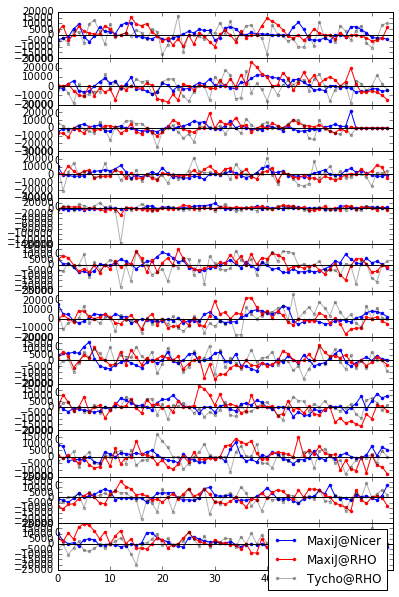

In [217]:
# plot of time series over chunk of data
# redo for x-ray-defined overlap
ctot = len(ochunk_kfix)
fig2,ax1=plt.subplots(figsize=[6,10],facecolor='w')
subplots_adjust(hspace=0.000)
for c,v in zip(ochunk_kfix,xrange(ctot)):
    ch = str(c)
    v = v+1
    ax1 = subplot(ctot,1,v)
    ax1.plot(tc, ochunk_datadict[ch]['xray_maxij_med_ts'],'.-b')
    ax1.plot(tc, ochunk_datadict[ch]['rho_maxij_med_ts'],'.-r')
    ax1.plot(tc, ochunk_datadict[ch]['rho_tycho_med_ts'],'.-k',alpha=.3)
    ax1.plot([0,ntot],[0,0],'k')
    ax1.set_xlim(0,ntot)
ax1.legend(['MaxiJ@Nicer','MaxiJ@RHO',"Tycho@RHO"])

## code is good to here as of 10/15!!

In [193]:
def pds_single_chunk(flx):
    clength = len(flx)
    t = xrange(clength)
    freqlength = clength/2
    freq = np.arange(freqlength)/(np.float(clength))
    af = np.fft.fft(flx)
    power = np.abs(af[:freqlength])**2
    
    return freq,power   

(97, 64)


(0, 1000000000000.0)

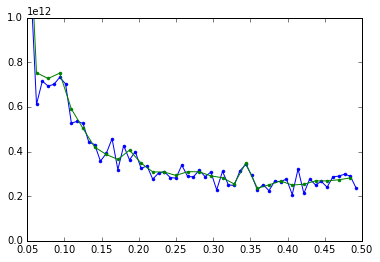

In [194]:
c128 = 2*np.arange(ctot/2)
overlap128 = []
powerspec128 = []
powerspec64 = []
for c in c128: 
#     fluxes_rho_maxij = np.ravel([list(datadict[str(c)]['rho_maxij_med_ts']),
#                       list(datadict[str(c+1)]['rho_maxij_med_ts'])])
    freq64,power = pds_single_chunk(datadict[str(c)]['rho_maxij_fixed_ts'])
    powerspec64.append(power)
    freq64,power = pds_single_chunk(datadict[str(c+1)]['rho_maxij_fixed_ts'])
    powerspec64.append(power)
    
    fluxes_rho_maxij = np.ravel([list(datadict[str(c)]['rho_maxij_fixed_ts']),
                      list(datadict[str(c+1)]['rho_maxij_fixed_ts'])])
    
    c128_times = np.ravel([list(datadict[str(c)]['unix_time']),
                      list(datadict[str(c+1)]['unix_time'])])
#     print c128_times-optical_time_seconds[0]
    
    if c in overlap or (c+1) in overlap: 
        overlap128.append(c/2)
        
    freq128,power = pds_single_chunk(fluxes_rho_maxij)
    powerspec128.append(power)
    
# print overlap128
# print [v/2 for v in overlap]
powerspec64=np.asarray(powerspec64)
powerspec128 = np.asarray(powerspec128)
print np.shape(powerspec128)
ptot=np.sum(powerspec128,axis=0)
plt.plot(freq128,ptot,'.-b')
plt.plot(freq64,np.sum(powerspec64,axis=0),'.-g')
plt.xlim(0.05,.5)
plt.ylim(0,1e12)

In [ ]:
#plot 2d power spectrum, 
#add markers for overlap areas
#optional: plot lightcurve vertically next to 2dps

In [195]:

def p_2_logp(f, p, df, n_avg):
    # takes output of pds_chunk128-style program
    # averages over n_avg pieces, and logbins the 2D array

    nt = p.shape[0]  # number of power spectra
    
    for i in range(nt):
        i1 = i - n_avg / 2
        i2 = i1 + n_avg / 2
        if i1 < 0:
            i1 = 0
        if i2 > (nt - 1):
            i2 = nt - 1
        pmean = np.mean(p[i1:i2 + 1, :], axis=0) / (np.mean(p[i1:i2 + 1, 0]) ** 0.5)
        dumf, dump = logbin(f, pmean, df)
        if i == 0:
            nf = len(dump[dump > 0])
            p2 = np.zeros([nt, nf])
            f2 = dumf[dump > 0]
        p2[i, :] = dump[dump > 0]

    return f2, p2

# f2,p2max=p_2_logp(f,pmax,0.03,8)

In [196]:
logfreq64, logpsd_rho_maxij64 = p_2_logp(freq64,powerspec64,0.03,4)
logfreq128, logpsd_rho_maxij128 = p_2_logp(freq128,powerspec128,0.03,4)
# print logflx[:1]
# print np.shape(logpsd_rho_maxij)

In [197]:
rho_maxij_map128 = np.asarray((10.**logfreq128[:1])*(logpsd_rho_maxij128[:,1:]))
rho_maxij_map64 = np.asarray((10.**logfreq64[:1])*(logpsd_rho_maxij64[:,1:]))
# print rho_maxij_map
print np.shape(rho_maxij_map128)
print np.shape(rho_maxij_map64)

(97, 34)
(194, 23)


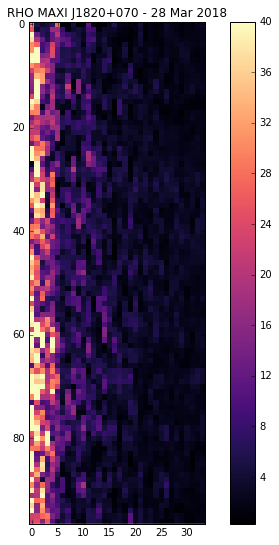

In [198]:
fig,ax=plt.subplots(figsize=(9,9), facecolor='w')
plt.imshow(rho_maxij_map128, vmax = 40, cmap='magma',interpolation='none')
# plt.plot([4.1,4.1],[0,86],c='r',linestyle='--')
# ax.plot([10.25,10.25],[0,86],c='r',linestyle='--')
ax.set_title('RHO MAXI J1820+070 - 28 Mar 2018')

plt.colorbar()


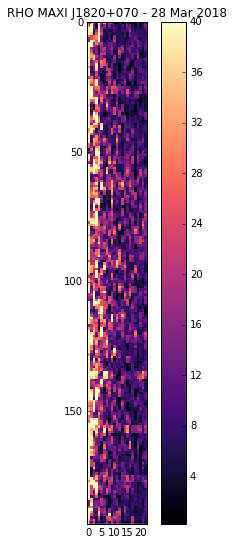

In [199]:
fig,ax=plt.subplots(figsize=(5,9), facecolor='w')
plt.imshow(rho_maxij_map64, vmax = 40, cmap='magma',interpolation='none')
# plt.plot([4.1,4.1],[0,86],c='r',linestyle='--')
# ax.plot([10.25,10.25],[0,86],c='r',linestyle='--')
ax.set_title('RHO MAXI J1820+070 - 28 Mar 2018')

plt.colorbar()


In [200]:
# maxifluxts=np.ravel([datadict[str(c)]['rho_maxij_med_ts'] for c in xrange(ctot)])
# print len(maxifluxts)
# print len(optical_time_seconds)
# print len(ots)
# # f,pmax,pmaxtot = pds_chunk_n(optical_time_seconds,ots-np.median(ots),0,12300,128.0)
# f,pmax,pmaxtot = pds_chunk128(np.arange(len(maxifluxts)),maxifluxts,0,len(ots))
# # f2,p2 = pds_single_chunk(datadict[str(c)]['rho_maxij_med_ts'])
# # print pmaxtot
# print np.shape(pmax)
# plt.plot(f,pmaxtot,'.')

In [201]:
# #ACFs & CCFs: 
# acf_xray_maxij = {}
# acf_rho_maxij = {}
# acf_rho_tycho = {}

# ccf_xray_rho_maxij = {}
# ccf_xray_maxij_rho_tycho_control = {}
# crosscorr_rho_maxij_tycho_weather = {}

# for c in overlap: 
#     xts_cm = datadict[str(c)]['xray_maxij_med_ts']
#     ots_cm = datadict[str(c)]['rho_maxij_med_ts']
#     tts_cm = datadict[str(c)]['rho_tycho_med_ts']
#     ch = str(c)
    
    
#     acf_xray_maxij[ch] = fftconvolve(xts_cm,xts_cm[::-1],mode='same') #x-ray autocorrelation
#     acf_rho_maxij[ch] = fftconvolve(ots_cm,ots_cm[::-1],mode='same') #optical autocorrelation
#     acf_rho_tycho[ch] = fftconvolve(tts_cm,tts_cm[::-1],mode='same') #tycho reference star autocorrelation

#     ccf_xray_rho_maxij[ch] = fftconvolve(xts_cm,ots_cm[::-1],mode='same') # cross correlation
#     ccf_xray_maxij_rho_tycho_control[ch] = fftconvolve(xts_cm,tts_cm[::-1],mode='same') # cross corr'ln w/ refstar
#     crosscorr_rho_maxij_tycho_weather[ch] = fftconvolve(ots_cm,tts_cm[::-1],mode='same')




In [ ]:
# ochunk_datadict = datadict
# ochunk_keys = np.arange(k)

In [218]:
#ACFs & CCFs: 
# redo with x-ray-defined overlap
acf_xray_maxij = {}
acf_rho_maxij = {}
acf_rho_tycho = {}

ccf_xray_rho_maxij = {}
ccf_xray_maxij_rho_tycho_control = {}
crosscorr_rho_maxij_tycho_weather = {}

for k in ochunk_kfix: 
    ch = str(k)
    xts_cm = ochunk_datadict[ch]['xray_maxij_med_ts']
    ots_cm = ochunk_datadict[ch]['rho_maxij_med_ts']
    tts_cm = ochunk_datadict[ch]['rho_tycho_med_ts']
    
    
    
    acf_xray_maxij[ch] = fftconvolve(xts_cm,xts_cm[::-1],mode='same') #x-ray autocorrelation
    acf_rho_maxij[ch] = fftconvolve(ots_cm,ots_cm[::-1],mode='same') #optical autocorrelation
    acf_rho_tycho[ch] = fftconvolve(tts_cm,tts_cm[::-1],mode='same') #tycho reference star autocorrelation

    ccf_xray_rho_maxij[ch] = fftconvolve(xts_cm,ots_cm[::-1],mode='same') # cross correlation
    ccf_xray_maxij_rho_tycho_control[ch] = fftconvolve(xts_cm,tts_cm[::-1],mode='same') # cross corr'ln w/ refstar
    crosscorr_rho_maxij_tycho_weather[ch] = fftconvolve(ots_cm,tts_cm[::-1],mode='same')


In [207]:
# fig10,ax=plt.subplots(figsize=[8,12],facecolor='w')
# subplots_adjust(hspace=0.1000)
# ctot = len(overlap)
# fig10.tight_layout()
# fig10.subplots_adjust(top=.95)
# fig10.suptitle('CCFs of all overlapping chunks of 64-second data',fontsize=16)

# for c,v in zip(overlap,xrange(np.size(overlap))):
#     v = v+1
#     ax = subplot(ctot,1,v)
#     ch = str(c)
#     ax.plot(ccf_xray_rho_maxij[ch],'g',linewidth=2)
#     ax.plot(ccf_xray_maxij_rho_tycho_control[ch],'c', linewidth=2)
#     ax.plot(crosscorr_rho_maxij_tycho_weather[ch], 'm',alpha=.3, linewidth=2)
#     ax.axvline(x=ntot/2.,color='y',alpha=.7)
#     ax.axhline(y=0,color='k')
# # ax.plot(crosscorr_xo - crosscorr_xt,'k')
# # ax.plot(auto_o/4,'r')
# # ax.plot(auto_x,'b')
# # ax.plot(auto_t/3,'k')
# #     ax.plot([np.argmax(auto_x),np.argmax(auto_x)],[-4.e9,2.e10],'y',alpha=.7)
# #     ax.set_ylim(-2.5e9,2.5e9)
#     ax.set_xlim(0,ntot)
# #     ax.set_xlim(20,40)

# # ax.set_title('Optical+X-ray Correlation (one chunk of 128-second overlapping data) 51.5s lead')
# ax.legend(['MaxiJ@Nicer/MaxiJ@RHO',
#            'MaxiJ@Nicer/Tycho@RHO',
#            'MaxiJ@RHO/Tycho@RHO',
#            # 'RHO Optical Auto-correlation',
#            # 'Nicer X-ray Auto-correlation',
#            # 'RHO Tycho Reference Auto-correlation',
# #            'Autocorrelation Peak'
#           ],
#          loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=3)

# # print np.argmax(crosscorr_xo)


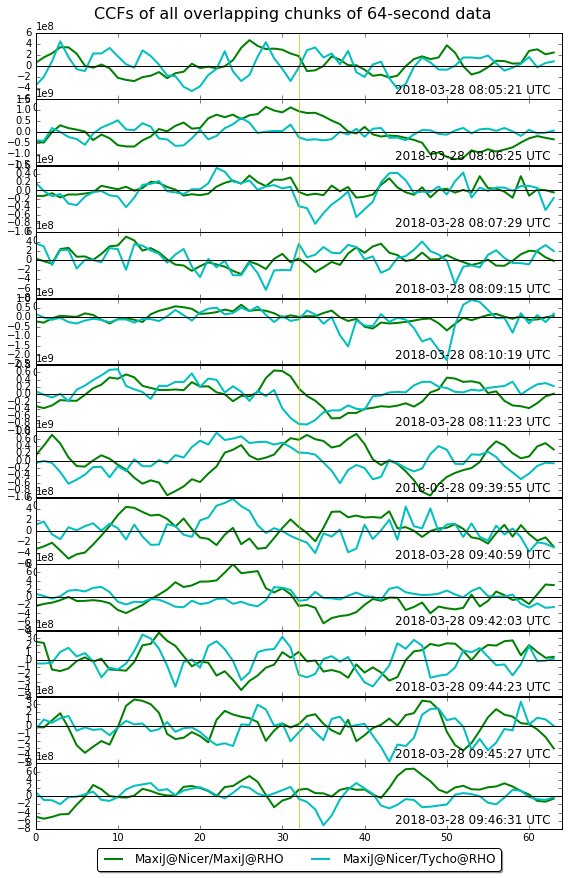

In [241]:
# redo with x-ray-defined overlap
fig10,ax=plt.subplots(figsize=[8,12],facecolor='w')
subplots_adjust(hspace=0.01000)
ctot = len(ochunk_kfix)
fig10.tight_layout()
fig10.subplots_adjust(top=.95)
fig10.suptitle('CCFs of all overlapping chunks of 64-second data',fontsize=16)

for c,v in zip(ochunk_kfix,xrange(ctot)):
    v = v+1
    ax = subplot(ctot,1,v)
    ch = str(c)
    ax.plot(ccf_xray_rho_maxij[ch],'g',linewidth=2)
    ax.plot(ccf_xray_maxij_rho_tycho_control[ch],'c', linewidth=2)
#     ax.plot(crosscorr_rho_maxij_tycho_weather[ch], 'm',alpha=.3, linewidth=2)
    ax.axvline(x=ntot/2.,color='y',alpha=.7)
    ax.axhline(y=0,color='k')
    titletime = ochunk_datadict[ch]['unix_time'][0]
    ax.set_title(datetime.utcfromtimestamp(titletime).strftime('%Y-%m-%d %H:%M:%S') + " UTC", x=.83, y=0)
# ax.plot(crosscorr_xo - crosscorr_xt,'k')
# ax.plot(auto_o/4,'r')
# ax.plot(auto_x,'b')
# ax.plot(auto_t/3,'k')
#     ax.plot([np.argmax(auto_x),np.argmax(auto_x)],[-4.e9,2.e10],'y',alpha=.7)
#     ax.set_ylim(-2.5e9,2.5e9)
    ax.set_xlim(0,ntot)
#     ax.set_xlim(20,40)

# ax.set_title('Optical+X-ray Correlation (one chunk of 128-second overlapping data) 51.5s lead')
ax.legend(['MaxiJ@Nicer/MaxiJ@RHO',
           'MaxiJ@Nicer/Tycho@RHO',
#            'MaxiJ@RHO/Tycho@RHO',
           # 'RHO Optical Auto-correlation',
           # 'Nicer X-ray Auto-correlation',
           # 'RHO Tycho Reference Auto-correlation',
#            'Autocorrelation Peak'
          ],
         loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

# print np.argmax(crosscorr_xo)


In [242]:
# mark above plots with time!!!! and toss out any with not enough x-ray data 
#(first, last, at least one in the middle)
## done, for ochunk version yay

In [ ]:
# # mean of all (good) CCFs
# #plot cross correlations
# fig3,ax=plt.subplots(figsize=[10,8],facecolor='w')
# g = np.zeros(len(overlap))<1
# bad = [0, 4, 5, 7, 12,15]
# for x in bad: 
#     g[x] = False 
# g=np.asarray(g)

# ax.plot(xrange(-32,32),np.mean([ccf_xray_rho_maxij[str(c)] for c in overlap[g]],axis=0),'g', lw=2)
# ax.plot(xrange(-32,32),np.mean([ccf_xray_maxij_rho_tycho_control[str(c)] for c in overlap[g]],axis=0),'k',alpha=.8,lw = 2)
# ax.axvline(x=0,color='r',lw = 2)
# ax.axhline(y=0,color='k')
# ax.legend(['NICER BH : RHO BH','NICER BH : Reference Star (Noise)'],
#          loc='upper center', bbox_to_anchor=(0.5, -0.1),
#           fancybox=True, shadow=True, ncol=1, fontsize=20)
# # ax.set_title('Mean Cross-Correlation of X-ray to Optical \n over Five one-minute Data Segments', 
# #             fontsize = 25)
# ax.set_title("mean ccf of x-ray to optical in a bunch of one-minute data segments")
# ax.set_xlim(-32,32)
# ax.tick_params(axis='both', which='major', labelsize=16)
# ax.set_xlabel('Seconds',fontsize=16)
# ax.set_ylabel('Amplitude',fontsize=16)


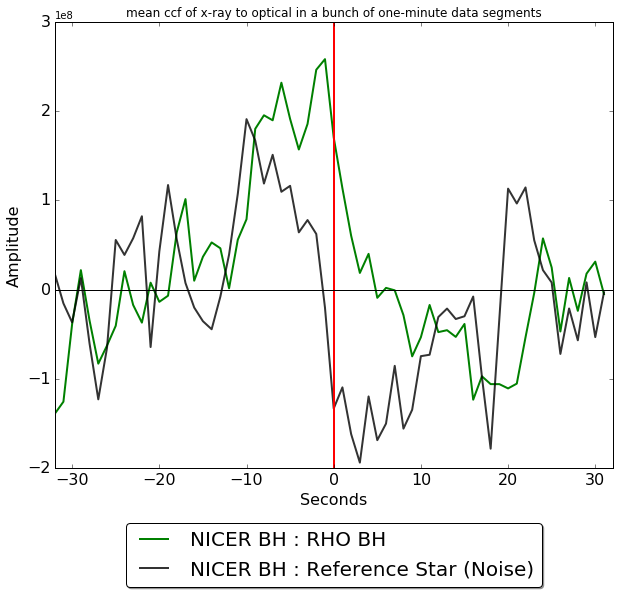

In [243]:
# mean of all (good) CCFs
#plot cross correlations
# now for x-ray defined version!

fig3,ax=plt.subplots(figsize=[10,8],facecolor='w')
# g = np.zeros(len(overlap))<1
# bad = [0, 4, 5, 7, 12,15]
# for x in bad: 
#     g[x] = False 
# g=np.asarray(g)

ax.plot(xrange(-32,32),np.mean([ccf_xray_rho_maxij[str(c)] for c in ochunk_kfix],axis=0),'g', lw=2)
ax.plot(xrange(-32,32),np.mean([ccf_xray_maxij_rho_tycho_control[str(c)] for c in ochunk_kfix],axis=0),'k',alpha=.8,lw = 2)
ax.axvline(x=0,color='r',lw = 2)
ax.axhline(y=0,color='k')
ax.legend(['NICER BH : RHO BH','NICER BH : Reference Star (Noise)'],
         loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=1, fontsize=20)
# ax.set_title('Mean Cross-Correlation of X-ray whaaaato Optical \n over Five one-minute Data Segments', 
#             fontsize = 25)
ax.set_title("mean ccf of x-ray to optical in a bunch of one-minute data segments")
ax.set_xlim(-32,32)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Seconds',fontsize=16)
ax.set_ylabel('Amplitude',fontsize=16)


In [244]:
# # cross power spectrum stuff with non-medianized data
# c = overlap[1]

# ts3a = datadict[str(c)]['xray_maxij_fixed_ts']
# ts3b = datadict[str(c)]['rho_maxij_fixed_ts']
# ts3c = datadict[str(c)]['rho_tycho_fixed_ts']

# dum0a=fftconvolve(ts3a,ts3a[::-1]) # ACF for maxij xray
# dum0b=fftconvolve(ts3b,ts3b[::-1]) # ACF for maxi j optical
# dum0c=fftconvolve(ts3c,ts3c[::-1]) # ACF for tycho star

# dum3=fftconvolve(ts3a,ts3b[::-1]) # cross-correlate = CCF of xray w/ optical (maxij)
# dum4=fftconvolve(ts3a,ts3c[::-1]) # ccf of xray w/ tycho


In [ ]:
# xray_maxij_ts = {}
# rho_maxij_ts = {}
# rho_tycho_ts = {}

# datadict2 = {}

# for c in overlap: 
#     ch = str(c)
#     xray_maxij_ts[ch] = datadict[str(c)]['xray_maxij_fixed_ts']
#     rho_maxij_ts[ch] = datadict[str(c)]['rho_maxij_fixed_ts']
#     rho_tycho_ts[ch] = datadict[str(c)]['rho_tycho_fixed_ts']
    
#     chunkdict = {'acf_xray_maxij':fftconvolve(xray_maxij_ts[ch], xray_maxij_ts[ch][::-1]), 
#                  'acf_rho_maxij':fftconvolve(rho_maxij_ts[ch], rho_maxij_ts[ch][::-1]),
#                  'acf_rho_tycho':fftconvolve(rho_tycho_ts[ch], rho_tycho_ts[ch][::-1]),
                 
#                  'ccf_xray_rho_maxij':fftconvolve(xray_maxij_ts[ch],rho_maxij_ts[ch][::-1]), # cross-correlate = CCF of xray w/ optical (maxij)
#                  'ccf_xray_maxij_rho_tycho_control':fftconvolve(xray_maxij_ts[ch],rho_tycho_ts[ch][::-1]), # ccf of xray w/ tycho
                 
#                  'fft_xray_maxij': np.fft.fft(xray_maxij_ts[ch]),
#                  'fft_rho_maxij': np.fft.fft(rho_maxij_ts[ch]),
#                  'fft_rho_tycho': np.fft.fft(rho_tycho_ts[ch])
#                 }
# #     chunkframe = pd.DataFrame(chunkdict)
#     datadict2[ch]= chunkdict
    

In [245]:
xray_maxij_ts = {}
rho_maxij_ts = {}
rho_tycho_ts = {}

datadict2 = {}

for c in ochunk_kfix: 
    ch = str(c)
    xray_maxij_ts[ch] = ochunk_datadict[str(c)]['xray_maxij_fixed_ts']
    rho_maxij_ts[ch] = ochunk_datadict[str(c)]['rho_maxij_fixed_ts']
    rho_tycho_ts[ch] = ochunk_datadict[str(c)]['rho_tycho_fixed_ts']
    
    chunkdict = {'acf_xray_maxij':fftconvolve(xray_maxij_ts[ch], xray_maxij_ts[ch][::-1]), 
                 'acf_rho_maxij':fftconvolve(rho_maxij_ts[ch], rho_maxij_ts[ch][::-1]),
                 'acf_rho_tycho':fftconvolve(rho_tycho_ts[ch], rho_tycho_ts[ch][::-1]),
                 
                 'ccf_xray_rho_maxij':fftconvolve(xray_maxij_ts[ch],rho_maxij_ts[ch][::-1]), # cross-correlate = CCF of xray w/ optical (maxij)
                 'ccf_xray_maxij_rho_tycho_control':fftconvolve(xray_maxij_ts[ch],rho_tycho_ts[ch][::-1]), # ccf of xray w/ tycho
                 
                 'fft_xray_maxij': np.fft.fft(xray_maxij_ts[ch]),
                 'fft_rho_maxij': np.fft.fft(rho_maxij_ts[ch]),
                 'fft_rho_tycho': np.fft.fft(rho_tycho_ts[ch])
                }
#     chunkframe = pd.DataFrame(chunkdict)
    datadict2[ch]= chunkdict

In [ ]:
# ch = str(overlap[0])
# print ch
# jnk1 = datadict2[ch]['fft_xray_maxij']
# jnk2 = datadict2[ch]['fft_rho_maxij']
# jnk3 = datadict2[ch]['fft_rho_tycho']

In [ ]:
# jnk1=np.fft.fft(ts3a) #xray maxij
# jnk2=np.fft.fft(ts3b) #optical maxij
# jnk3=np.fft.fft(ts3c) #tycho

In [ ]:
# fig,ax=plt.subplots(figsize=[9,6])
# ax.plot(ts3a,'b')
# ax.plot(ts3b,'r')
# ax.plot(ts3c,'g')
# #fluxes/ts

In [ ]:
# nel2=len(jnk1)/2
# # f=np.arange(nel2)/np.max(t)
# f = np.arange(nel2)/64.
# fig,ax=plt.subplots(figsize=[9,6])
# ax.plot(f,np.abs(((jnk1[:nel2]))**2)/np.abs(((jnk1[:nel2]))**2)[0],'b.-') #xray maxij
# ax.plot(f,np.abs(((jnk2[:nel2]))**2)/np.abs(((jnk2[:nel2]))**2)[0],'r.-') #optical maxij
# ax.plot(f,np.abs(((jnk3[:nel2]))**2)/np.abs(((jnk3[:nel2]))**2)[0],'g.-') #tycho

# print np.abs(((jnk1[:nel2]))**2)[0]
# print np.abs(((jnk2[:nel2]))**2)[0]
# print np.abs(((jnk3[:nel2]))**2)[0]
# # ax.set_xlim(0,2.3e-7)
# ax.set_ylim(0,.007)
# ax.set_xlabel('frequency')
# ax.set_title('normalized FFTs')

In [ ]:
# ch = str(overlap[5])
# nel2=len(datadict2[ch]['fft_xray_maxij'])/2
# # f=np.arange(nel2)/np.max(t)
# f = np.arange(nel2)/64.
# fig,ax=plt.subplots(figsize=[9,6])
# ax.plot(f,np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)[0],'b.-') #xray maxij
# ax.plot(f,np.abs(((datadict2[ch]['fft_rho_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_rho_maxij'][:nel2]))**2)[0],'r.-') #optical maxij
# ax.plot(f,np.abs(((datadict2[ch]['fft_rho_tycho'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_rho_tycho'][:nel2]))**2)[0],'g.-') #tycho

# print np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)[0]
# print np.abs(((datadict2[ch]['fft_rho_maxij'][:nel2]))**2)[0]
# print np.abs(((datadict2[ch]['fft_rho_tycho'][:nel2]))**2)[0]
# # ax.set_xlim(0,2.3e-7)
# ax.set_ylim(0,.007)
# ax.set_xlabel('frequency')
# ax.set_title('normalized FFTs')

1445294457616.0
20712926744402.94
475206227280012.6


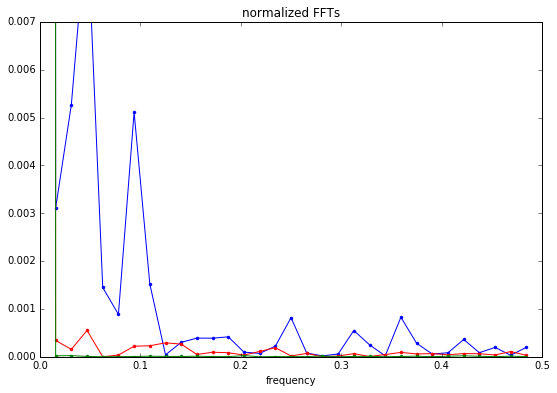

In [246]:
ch = str(ochunk_kfix[5])
nel2=len(datadict2[ch]['fft_xray_maxij'])/2
# f=np.arange(nel2)/np.max(t)
f = np.arange(nel2)/64.
fig,ax=plt.subplots(figsize=[9,6])
ax.plot(f,np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)[0],'b.-') #xray maxij
ax.plot(f,np.abs(((datadict2[ch]['fft_rho_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_rho_maxij'][:nel2]))**2)[0],'r.-') #optical maxij
ax.plot(f,np.abs(((datadict2[ch]['fft_rho_tycho'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_rho_tycho'][:nel2]))**2)[0],'g.-') #tycho

print np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)[0]
print np.abs(((datadict2[ch]['fft_rho_maxij'][:nel2]))**2)[0]
print np.abs(((datadict2[ch]['fft_rho_tycho'][:nel2]))**2)[0]
# ax.set_xlim(0,2.3e-7)
ax.set_ylim(0,.007)
ax.set_xlabel('frequency')
ax.set_title('normalized FFTs')

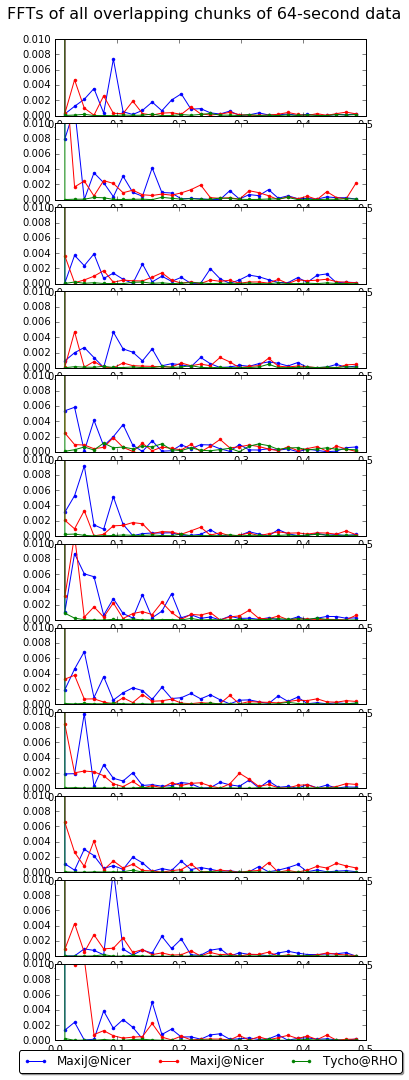

In [249]:
fig10,ax=plt.subplots(figsize=[5,15],facecolor='w')
subplots_adjust(hspace=0.1000)
ctot = len(ochunk_kfix)
fig10.tight_layout()
fig10.subplots_adjust(top=.95)
fig10.suptitle('FFTs of all overlapping chunks of 64-second data',fontsize=16)

for c,v in zip(ochunk_kfix,xrange(ctot)):
    v = v+1
    ax = subplot(ctot,1,v)
    ch = str(c)
    ax.plot(f,np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)[0],'b.-') #xray maxij
    ax.plot(f,6*np.abs(((datadict2[ch]['fft_rho_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_rho_maxij'][:nel2]))**2)[0],'r.-') #optical maxij
    ax.plot(f,10*np.abs(((datadict2[ch]['fft_rho_tycho'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_rho_tycho'][:nel2]))**2)[0],'g.-') #tycho
    ax.axvline(x=ntot/2.,color='y',alpha=.7)
    ax.axhline(y=0,color='k')
# ax.plot(crosscorr_xo - crosscorr_xt,'k')
# ax.plot(auto_o/4,'r')
# ax.plot(auto_x,'b')
# ax.plot(auto_t/3,'k')
#     ax.plot([np.argmax(auto_x),np.argmax(auto_x)],[-4.e9,2.e10],'y',alpha=.7)
    ax.set_ylim(0,.01)
#     ax.set_xlim(0,ntot)
    ax.set_xlim(0,.5)

# ax.set_title('Optical+X-ray Correlation (one chunk of 128-second overlapping data) 51.5s lead')
ax.legend(['MaxiJ@Nicer',
           'MaxiJ@Nicer',
           'Tycho@RHO',
           # 'RHO Optical Auto-correlation',
           # 'Nicer X-ray Auto-correlation',
           # 'RHO Tycho Reference Auto-correlation',
#            'Autocorrelation Peak'
          ],
         loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

# print np.argmax(crosscorr_xo)


In [253]:
# pwr_array = []
# ctot = len(ots_c)
# pwrlen = len(datadict2[str(ochunk_kfix[0])]['fft_xray_maxij'][:nel2])
# dummy = np.ones(pwrlen)
# for c in xrange(ctot): 
# # for c in overlap: 
#     ch = str(c)
# #      pwr_array.append((((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)[0])
#     if c in overlap: 
#         pwr_array.append(np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))[0])
#     else: 
#         pwr_array.append(dummy)
            
# pwr_array = np.asarray(pwr_array)
# # print pwr_array
# logfreq_xpwr, logxpwr_maxij64 = p_2_logp(f,pwr_array,0.03,4)
# rho_maxij_xpwrmap64 = np.asarray((10.**logfreq_xpwr[:1])*(logxpwr_maxij64[:,1:]))
# fig,ax=plt.subplots(figsize=(10,15), facecolor='w')
# plt.imshow(rho_maxij_xpwrmap64, cmap='magma',interpolation='none',vmax = 4E-5)
# ax.set_title('RHO MAXI J1820+070 - 28 Mar 2018')

# plt.colorbar()


In [255]:
# pwr_array = []
# ctot = len(ots_c)
# pwrlen = len(datadict2[str(overlap[0])]['fft_xray_maxij'][:nel2])
# dummy = np.ones(pwrlen)
# for c in xrange(ctot): 
# # for c in overlap: 
#     ch = str(c)
# #      pwr_array.append((((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)[0])
#     if c in overlap: 
#         pwr_array.append(np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))[0])
#     else: 
#         pwr_array.append(dummy)
            
# pwr_array = np.asarray(pwr_array)
# # print pwr_array
# logfreq_xpwr, logxpwr_maxij64 = p_2_logp(f,pwr_array,0.03,4)
# rho_maxij_xpwrmap64 = np.asarray((10.**logfreq_xpwr[:1])*(logxpwr_maxij64[:,1:]))
# fig,ax=plt.subplots(figsize=(10,15), facecolor='w')
# plt.imshow(rho_maxij_xpwrmap64, cmap='viridis',interpolation='none',vmax = 4E-5)
# ax.set_title('X-ray:Tycho (control) XPS MAXI J1820+070 - 28 Mar 2018')

# plt.colorbar()


In [ ]:
pwr_array = []
ctot = len(ots_c)
pwrlen = len(datadict2[str(overlap[0])]['fft_xray_maxij'][:nel2])
dummy = np.ones(pwrlen)
for c in xrange(ctot): 
# for c in overlap: 
    ch = str(c)
#      pwr_array.append((((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)[0])
    if c in overlap: 
        pwr_array.append(np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))[0])
#     else: 
#         pwr_array.append(dummy)
            
pwr_array = np.asarray(pwr_array)
# print pwr_array
logfreq_xpwr, logxpwr_maxij64 = p_2_logp(f,pwr_array,0.03,2)
rho_maxij_xpwrmap64 = np.asarray((10.**logfreq_xpwr[:1])*(logxpwr_maxij64[:,1:]))
fig,ax=plt.subplots(figsize=(10,6), facecolor='w')
plt.imshow(rho_maxij_xpwrmap64, cmap='viridis',interpolation='none',vmax = 4E-5)
ax.set_title('Crosspower Spectrum X-ray:Optical Maxi J1820+070 - 28 Mar 2018')

plt.colorbar()


In [259]:
# c = 6
# ch = str(ochunk_kfix[c])
# xps = np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))[0]
# tycho_xps = np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))[0]

# fig,ax=plt.subplots(figsize=(10,6), facecolor='w')
# # ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
# # ax.set_xscale('log')

# ax.plot(f[f>0],xps[f>0],'g-',drawstyle='steps-mid',lw = 3)
# ax.plot(f[f>0],tycho_xps[f>0],'-k',drawstyle='steps-mid',alpha=.5, lw = 3)
# # ax.axvline(x=0.0225,color='y',linestyle='--')
# ax.axvline(x=0.09,c='r',linestyle='--',lw=2)
# ax.axvline(x=0.045,c='r',linestyle='--',lw=2)
# # ax.axvline(x=0.18,color='y',linestyle='--')

# ax.set_ylim(0,.002)
# ax.set_xlim(0,.5)
# ax.legend(['Maxi J1820+070 X-ray:Optical', 'Maxi J1820+070 X-ray:Reference Star Optical','Previously Identified QPOs'])
# ax.set_xlabel('Frequency (Hz)')
# ax.set_ylabel('Normalized Power')
# ax.set_title('Crosspower Spectrum - Maxi J1820+070 \n (60s of data, 28 Mar 2018)')


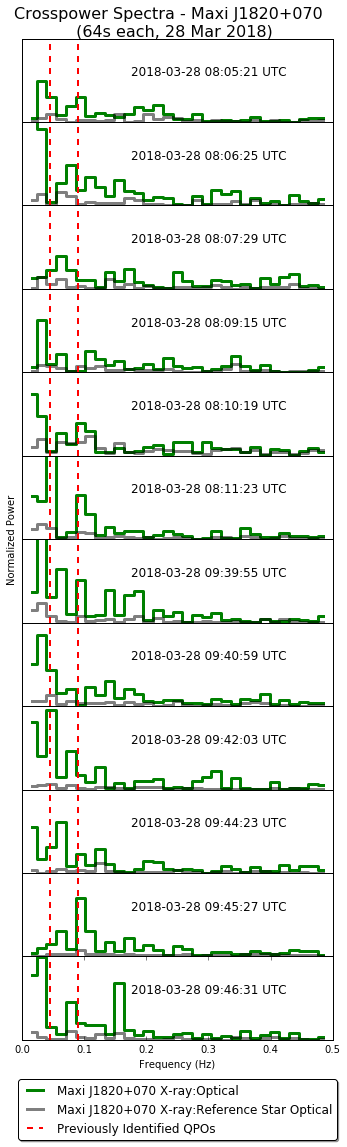

In [284]:
fig10,ax=plt.subplots(figsize=[5,15],facecolor='w')
subplots_adjust(hspace=0.0000)
ctot = len(ochunk_kfix)
fig10.tight_layout()
fig10.subplots_adjust(top=.95)
fig10.suptitle('Crosspower Spectra - Maxi J1820+070 \n (64s each, 28 Mar 2018)',fontsize=16)

for c,v in zip(ochunk_kfix,xrange(ctot)):
    v = v+1
    ax = subplot(ctot,1,v)
    ch = str(c)
    
    xps = np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))[0]
    tycho_xps = np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))[0]

    ax.plot(f[f>0],xps[f>0],'g-',drawstyle='steps-mid',lw = 3)
    ax.plot(f[f>0],tycho_xps[f>0],'-k',drawstyle='steps-mid',alpha=.5, lw = 3)
    # ax.axvline(x=0.0225,color='y',linestyle='--')
    ax.axvline(x=0.09,c='r',linestyle='--',lw=2)
    ax.axvline(x=0.045,c='r',linestyle='--',lw=2)
    # ax.axvline(x=0.18,color='y',linestyle='--')

    ax.set_ylim(0,.002)
    ax.set_xlim(0,.5)
    ax.get_yaxis().set_ticks([])
    if c != np.max(ochunk_kfix): 
        ax.get_xaxis().set_ticks([])
        
    titletime = ochunk_datadict[ch]['unix_time'][0]
    ax.set_title(datetime.utcfromtimestamp(titletime).strftime('%Y-%m-%d %H:%M:%S') + " UTC", x=.6, y=.5)
    
ax.legend(['Maxi J1820+070 X-ray:Optical', 'Maxi J1820+070 X-ray:Reference Star Optical','Previously Identified QPOs'],
         loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=1)


ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized Power', y=6)



In [287]:
def logbin(f,p,df):
    #df = step size in log frequency
    fx=np.zeros(len(f))
    px=np.zeros(len(p))
    fx[:]=f[:]
    fx[0]=fx[1]
    p0=p[0]
    px[:]=p[:]
    px[0]=0.

    fl=np.log10(fx)
    nel=len(f)

    fmin=fl[1]
    fmax=np.max(fl)

    nf=np.round((fmax-fmin)/df).astype(int)
    f2=np.arange(nf)*df+fmin
    p2=np.zeros(nf)

    for i in range(nf):
        fa=10.**f2[i]
        fb=10.**(f2[i]+df)
        fm=(fa+fb)/2.0
        dff=fm-fa
        if len(f[np.abs(f-fm)<=dff])>0:
            p2[i]=np.mean(px[np.abs(f-fm)<=dff])

    return f2,p2

In [ ]:
fig10,ax=plt.subplots(figsize=[5,15],facecolor='w')
subplots_adjust(hspace=0.0000)
ctot = len(ochunk_kfix)
fig10.tight_layout()
fig10.subplots_adjust(top=.95)
fig10.suptitle('Crosspower Spectra - Maxi J1820+070 \n (64s each, 28 Mar 2018)',fontsize=16)

for c,v in zip(ochunk_kfix,xrange(ctot)):
    v = v+1
    ax = subplot(ctot,1,v)
    ch = str(c)
    
    xps = np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_maxij'][:nel2])))[0]
    
    
    
    tycho_xps = np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))[0]

    ax.plot(f[f>0],xps[f>0],'g-',drawstyle='steps-mid',lw = 3)
    ax.plot(f[f>0],tycho_xps[f>0],'-k',drawstyle='steps-mid',alpha=.5, lw = 3)
    # ax.axvline(x=0.0225,color='y',linestyle='--')
    ax.axvline(x=0.09,c='r',linestyle='--',lw=2)
    ax.axvline(x=0.045,c='r',linestyle='--',lw=2)
    # ax.axvline(x=0.18,color='y',linestyle='--')

    ax.set_ylim(0,.002)
    ax.set_xlim(0,.5)
    ax.get_yaxis().set_ticks([])
    if c != np.max(ochunk_kfix): 
        ax.get_xaxis().set_ticks([])
        
    titletime = ochunk_datadict[ch]['unix_time'][0]
    ax.set_title(datetime.utcfromtimestamp(titletime).strftime('%Y-%m-%d %H:%M:%S') + " UTC", x=.6, y=.5)
    
ax.legend(['Maxi J1820+070 X-ray:Optical', 'Maxi J1820+070 X-ray:Reference Star Optical','Previously Identified QPOs'],
         loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=1)


ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized Power', y=6)



In [ ]:
dumf,dump=logbin(f,ptot/(ptot[0]**0.5),0.05)
dumfr,dumpr=logbin(f,prtot/(prtot[0]**0.5),0.05)

from matplotlib import ticker
fig,ax=plt.subplots(figsize=(9,6), facecolor='w')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xscale('log')

ax.plot(10.**dumf[dump>0],(10.**dumf[dump>0.0])*dump[dump>0],c='b',drawstyle='steps-mid')
ax.plot(10.**dumfr[dumpr>0],(10.**dumfr[dumpr>0.0])*dumpr[dumpr>0],c='g',drawstyle='steps-mid')


#ax.set_xlim(-2.0,0.65)
ax.set_ylim(0.,900)
ax.set_title('RHO MAXI J1820+070 - 29 March 2018 - 128s chunks')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('f x Power')
ax.plot([0.045,0.045],[0,1200],c='r',linestyle='--')
ax.plot([0.09,0.09],[0,1200],c='r',linestyle='--')
ax.plot([0.0225,0.0225],[0,1200],c='y',linestyle='--')
ax.plot([0.14,0.14],[0,900],c='g',linestyle='--')


ax.text(0.1,700,'MAXI J1820',color='b',size=20)
ax.text(0.1,280,'Ref Star',color='g',size=20)


In [286]:
# pwr_array = []
# ctot = len(ots_c)
# pwrlen = len(datadict2[str(overlap[0])]['fft_xray_maxij'][:nel2])
# dummy = np.ones(pwrlen)
# for c in xrange(ctot): 
# # for c in overlap: 
#     ch = str(c)
# #      pwr_array.append((((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)/np.abs(((datadict2[ch]['fft_xray_maxij'][:nel2]))**2)[0])
#     if c in overlap: 
#         pwr_array.append(np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))/np.abs((datadict2[ch]['fft_xray_maxij'][:nel2]*np.conj(datadict2[ch]['fft_rho_tycho'][:nel2])))[0])
# #     else: 
# #         pwr_array.append(dummy)
            
# pwr_array = np.asarray(pwr_array)
# # print pwr_array
# logfreq_xpwr, logxpwr_maxij64 = p_2_logp(f,pwr_array,0.03,2)
# rho_maxij_xpwrmap64 = np.asarray((10.**logfreq_xpwr[:1])*(logxpwr_maxij64[:,1:]))
# fig,ax=plt.subplots(figsize=(10,6), facecolor='w')
# plt.imshow(rho_maxij_xpwrmap64, cmap='viridis',interpolation='none',vmax = 4E-5)
# ax.set_title('Crosspower Spectrum X-ray:Tycho (control) - 28 Mar 2018')

# plt.colorbar()


In [ ]:



# fig,ax=plt.subplots(figsize=[9,6])
# ax.plot(f,np.abs((jnk1[:nel2]*np.conj(jnk2[:nel2])))/np.abs((jnk1[:nel2]*np.conj(jnk2[:nel2])))[0],'g')
# ax.plot(f,np.abs(jnk1[:nel2]*np.conj(jnk3[:nel2]))/np.abs(jnk1[:nel2]*np.conj(jnk3[:nel2]))[0],'c')
# # ax.set_xlim(0,2.3e-7)
# ax.set_ylim(0,.001)
# # ax.set_xlim(0.0,0.8)
# ax.set_xlabel('frequency')
# ax.set_title('normalized cross-power spectrum')
# ax.legend(['nicer:rho maxij', 'nicer maxij:rho tycho'])

In [ ]:

def p_2_logp(f, p, df, n_avg):
    # takes output of pds_chunk128-style program
    # averages over n_avg pieces, and logbins the 2D array

    nt = p.shape[0]  # number of power spectra
    
    for i in range(nt):
        i1 = i - n_avg / 2
        i2 = i1 + n_avg / 2
        if i1 < 0:
            i1 = 0
        if i2 > (nt - 1):
            i2 = nt - 1
        pmean = np.mean(p[i1:i2 + 1, :], axis=0) / (np.mean(p[i1:i2 + 1, 0]) ** 0.5)
        dumf, dump = logbin(f, pmean, df)
        if i == 0:
            nf = len(dump[dump > 0])
            p2 = np.zeros([nt, nf])
            f2 = dumf[dump > 0]
        p2[i, :] = dump[dump > 0]

    return f2, p2

# f2,p2max=p_2_logp(f,pmax,0.03,8)

In [ ]:
# fig,ax=plt.subplots(figsize=(9,9), facecolor='w')
# plt.imshow(rho_maxij_map, vmax = 40, cmap='viridis',interpolation='none')
# plt.plot([4.1,4.1],[0,86],c='r',linestyle='--')
# ax.plot([10.25,10.25],[0,86],c='r',linestyle='--')
# ax.set_title('RHO MAXI J1820+070 - 28 Mar 2018')

# plt.colorbar()


In [ ]:
# now redo the cps stuff for all overlapping chunks
#fix shitty variable names

In [ ]:
# # sphinx_gallery_thumbnail_number = 2

# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from matplotlib import cm
# from colorspacious import cspace_converter
# from collections import OrderedDict

# cmaps = OrderedDict()

# cmaps['Miscellaneous'] = [
#             'a', '', '', '', '', '',
#             '', '', 'b', '', '',
#             '', '', '', '', 'c']

# nrows = max(len(cmap_list) for cmap_category, cmap_list in cmaps.items())
# gradient = np.linspace(0, 1, 256)
# gradient = np.vstack((gradient, gradient))


# def plot_color_gradients(cmap_category, cmap_list, nrows):
#     fig, axes = plt.subplots(nrows=nrows,  facecolor='w')
# #     fig.subplots_adjust(top=1, bottom=0.00, left=0.2, right=0.99, hspace=0)
#     fig.subplots_adjust(left=0.2, right=0.99, hspace=0)
#     axes[0].set_title(cmap_category + ' colormaps', fontsize=14)
    
#     for ax, name in zip(axes, cmap_list):
#         gradient = np.random.randint(256, size=(1, 100))
#         ax.imshow(gradient, aspect='auto', cmap='magma_r',interpolation='None')
#         pos = list(ax.get_position().bounds)
#         x_text = pos[0] - 0.01
#         y_text = pos[1] + pos[3]/2.
#         fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

#     # Turn off *all* ticks & spines, not just the ones with colormaps.
#     for ax in axes:
#         ax.set_axis_off()


# for cmap_category, cmap_list in cmaps.items():
#     plot_color_gradients(cmap_category, cmap_list, nrows)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import gridspec

# t = np.linspace(0, 31.3, 100)
# f = np.linspace(0, 1000, 1000)
# a = np.exp(-np.abs(f-200)/200)[:, None] * np.random.rand(t.size)
# flim = (f.min(), f.max())
# tlim = (t.min(), t.max())

# gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
# ax = plt.subplot(gs[0,1])
# axl = plt.subplot(gs[0,0], sharey=ax)
# axb = plt.subplot(gs[1,1], sharex=ax)

# ax.imshow(a, origin='lower', extent=tlim+flim, aspect='auto')
# plt.xlim(tlim)

# axl.plot(a.mean(1), f)
# axb.plot(t, a.mean(0))


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import gridspec

# t = np.linspace(0, 31.3, 100)
# f = np.linspace(0, 1000, 1000)
# a = np.exp(-np.abs(f-200)/200)[:, None] * np.random.rand(t.size)
# flim = (f.min(), f.max())
# tlim = (t.min(), t.max())

# gs = gridspec.GridSpec(1, 3, width_ratios=[1,3])
# ax = plt.subplot(gs[0,2])
# axl = plt.subplot(gs[0,0], sharey=ax)


# ax.imshow(a, origin='lower', extent=tlim+flim, aspect='auto', cmap='viridis')
# ax.yaxis.set_visible(False)
# plt.xlim(tlim)

# axl.plot(a.mean(1), f)
# axl.set_xlim(0,np.max(a.mean(1)))


In [ ]:
# import numpy as np
# from matplotlib import pyplot as plt

# N = 100
# yRange = 1.0
# x = np.arange(N)
# y = np.random.random((N))*yRange

# imageX = 100
# imageY = 150
# image = np.random.random((imageY,imageX))

# imageAspect = float(imageY)/float(imageX)

# myDataAspect = float(N)/yRange * imageAspect

# fig = plt.figure()
# ax1 = plt.axes([0.05,0.05,0.45,0.9])
# ax2 = plt.axes([0.5,0.05,0.45,0.9], adjustable='box', aspect=myDataAspect)
# ax2.yaxis.tick_right()

# ax1.imshow(image)
# ax2.plot(x,y)

# # fig.savefig("test.png")

# # plt.show()